# Variable Star Lightcurve Analysis Pipeline

This notebook processes photometric observations of variable stars from AAVSO format data and converts them to BAV (Bundesdeutsche Arbeitsgemeinschaft für Veränderliche Sterne) standard formats. It serves as the first step in a comprehensive variable star analysis pipeline.

## Workflow Overview

1. **Data Import**: Read AAVSO report files with metadata and observations
2. **Coordinate Processing**: Query SIMBAD for precise J2000 coordinates
3. **Time Corrections**: Apply heliocentric corrections to observation times
4. **Lightcurve Visualization**: Generate publication-quality plots
5. **Format Conversion**: Export data in BAV-compliant formats
6. **Integration**: Prepare data for specialized analysis (exoplanet transits, eclipsing binaries, etc.)

## Input Data Format

The pipeline expects AAVSO report files containing:
- Header metadata (observer information, coordinates, filters)
- Photometric measurements (JD, magnitude, uncertainty)
- Ensemble comparison star information

In [22]:
import pandas as pd
from pathlib import Path
import requests

file_path = Path('data') / "AAVSO report for V0398 UMa on 2025-04-27 with ringset (8 - 5 - 7)_Created 2025-07-23 20-54-49.txt"

# Separate header comment lines and data lines
header_lines = []
data_lines = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.startswith('#'):
            header_lines.append(line.strip()[1:].strip())
        else:
            data_lines.append(line)

# Separate metadata headers and column names
# Last header line contains column names
col_line = header_lines[-1]
col_names = col_line.split(',')

# Build dictionary from header lines (excluding last line)
header_dict = {}
for hl in header_lines[:-1]:
    if '=' in hl:
        key, value = hl.split('=', 1)
        header_dict[key.strip()] = value.strip()

# Load data into DataFrame using extracted column names
from io import StringIO
df = pd.read_csv(StringIO(''.join(data_lines)), sep=',', header=None, names=col_names)
# Remove any spurious rows without a valid DATE
df = df[df['DATE'].notna()].reset_index(drop=True)

# Display results
print('Header metadata:')
for key, value in header_dict.items():
    if key in ("TYPE", "DELIM", "DATE"):
        continue
    if key == 'Ensemble Comps':
        print(f"{key}:")
        for comp in value.split(','):
            print(f"  - {comp.strip()}")
    else:
        print(f"{key}: {value}")

print('\nDataFrame head:')
print(df.head())

Header metadata:
OBSCODE: DPEB
SOFTWARE: Phoranso 1.1.0.7
OBSTYPE: CCD
Observer: Peter Deeskow
Observer Latitude: 51 26 15.0
Observer Longitude: 06 49 23.1
Ensemble Comps:
  - AUID 000-BNX-359
  - AUID 000-BNX-361
  - AUID 000-BNX-362
  - AUID 000-BNX-363
  - AUID 000-BNX-360

DataFrame head:
        NAME          DATE     MAG   MERR FILT TRANS MTYPE     CNAME CMAG  \
0  V0398 UMa  2.460793e+06  11.718  0.002    V    NO   STD  ENSEMBLE   na   
1  V0398 UMa  2.460793e+06  11.714  0.002    V    NO   STD  ENSEMBLE   na   
2  V0398 UMa  2.460793e+06  11.712  0.002    V    NO   STD  ENSEMBLE   na   
3  V0398 UMa  2.460793e+06  11.714  0.002    V    NO   STD  ENSEMBLE   na   
4  V0398 UMa  2.460793e+06  11.682  0.002    V    NO   STD  ENSEMBLE   na   

         KNAME    KMAG  AIRMASS GROUP      CHART  \
0  000-BNX-358  10.839    1.007    na  X40480BLM   
1  000-BNX-358  10.826    1.005    na  X40480BLM   
2  000-BNX-358  10.921    1.005    na  X40480BLM   
3  000-BNX-358  10.891    1.005    

# Coordinate System and Target Information

## SIMBAD Query for Precise Coordinates

To ensure accurate heliocentric corrections, we query the SIMBAD astronomical database for precise J2000 coordinates of our target object. This is crucial for:

- Accurate light travel time corrections
- Proper coordinate transformations
- Constellation determination for BAV naming conventions

The coordinates obtained here will be used throughout the analysis pipeline.

In [23]:
# New cell: query SIMBAD for J2000 coordinates based on object name in df
from astroquery.simbad import Simbad
import astropy.units as u

# assume df['NAME'] holds the target identifier
object_name = df['NAME'].iloc[0]
simbad = Simbad()
simbad.add_votable_fields('ra(d)', 'dec(d)')
result = simbad.query_object(object_name)

if result is None:
    raise ValueError(f"No SIMBAD entry found for '{object_name}'")

ra_j2000 = result['RA_d'][0]  # degrees
dec_j2000 = result['DEC_d'][0]

print(f"SIMBAD J2000 coordinates for {object_name}:")
print(f"  RA  = {ra_j2000} deg")
print(f"  Dec = {dec_j2000} deg")

SIMBAD J2000 coordinates for V0398 UMa:
  RA  = 177.17527113459 deg
  Dec = 54.71875584585 deg


## Get VSX Data if available

In [24]:
response = requests.get(f"http://www.aavso.org/vsx/index.php?view=api.object&ident={object_name}&format=json")   
vsx_data=response.json()['VSXObject']
vsx_data

{'Name': 'V0398 UMa',
 'AUID': '000-BJN-618',
 'RA2000': '177.17527',
 'Declination2000': '54.71876',
 'ProperMotionRA': '4.4720',
 'ProperMotionDec': '4.3620',
 'VariabilityType': 'HADS',
 'Period': '0.09134218',
 'Epoch': '2453489.29',
 'MaxMag': '11.7 R1',
 'MinMag': '12.1 R1',
 'Category': 'Variable',
 'OID': '186073',
 'Constellation': 'UMa'}

# Heliocentric Time Correction

## Light Travel Time Correction

Raw photometric observations are recorded in geocentric Julian Date (JD). For accurate period analysis and comparison with theoretical models, we must correct for the varying light travel time between Earth and the target as Earth orbits the Sun.

**Key corrections applied:**
- **Light Travel Time**: Accounts for Earth's orbital motion
- **Heliocentric Julian Date (HJD)**: Standard reference frame for variable star analysis
- **Observer Location**: Uses precise latitude/longitude from metadata

The heliocentric correction typically ranges from ±8.3 minutes depending on the target's ecliptic coordinates and time of year. This correction is essential for:
- Accurate period determination
- Comparison with literature values
- Multi-site observation coordination

In [25]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation

# Parse observer latitude/longitude from metadata
def dms2deg(dms_str):
    parts = dms_str.split()
    d, m, s = map(float, parts)
    sign = 1 if d >= 0 else -1
    return sign * (abs(d) + m/60 + s/3600)

obs_lat = dms2deg(header_dict['Observer Latitude'])
obs_lon = dms2deg(header_dict['Observer Longitude'])
location = EarthLocation(lat=obs_lat * u.deg, lon=obs_lon * u.deg, height=0 * u.m)

# Prepare coordinate and time
coord = SkyCoord(ra_j2000 * u.deg, dec_j2000 * u.deg, frame='icrs')
times = Time(df['DATE'].values, format='jd', scale='utc', location=location)

# Compute light travel time and heliocentric JD
ltt = times.light_travel_time(coord)
times_helio = times + ltt
df['HJD'] = times_helio.jd

# Compute and attach delta between HJD and original JD
df['Delta_HJD'] = df['HJD'] - df['DATE']

# Show sample of heliocentric correction
print('Original JD, HJD and Delta HJD:')
print(df[['DATE','HJD','Delta_HJD']].head())

Original JD, HJD and Delta HJD:
           DATE           HJD  Delta_HJD
0  2.460793e+06  2.460793e+06   0.001428
1  2.460793e+06  2.460793e+06   0.001428
2  2.460793e+06  2.460793e+06   0.001428
3  2.460793e+06  2.460793e+06   0.001428
4  2.460793e+06  2.460793e+06   0.001428


In [26]:
from astropy.coordinates import AltAz
import numpy as np

# Calculate airmass for all observation times
# Transform target coordinates to horizontal (AltAz) frame for each observation time
altaz_frame = AltAz(obstime=times, location=location)
coord_altaz = coord.transform_to(altaz_frame)

# Calculate airmass using secant formula: airmass = sec(zenith_angle)
# Zenith angle = 90° - altitude
zenith_angles = 90 * u.deg - coord_altaz.alt
airmass = 1.0 / np.cos(zenith_angles.to(u.rad))

# Add airmass to dataframe
df['AIRMASS'] = airmass.value

# Show sample of airmass calculations
print('Altitude, Zenith Angle and Airmass:')
print(f"{'JD':<12} {'Alt (deg)':<10} {'Zenith (deg)':<12} {'Airmass':<8}")
print("-" * 45)
for i in range(min(5, len(df))):
    alt = coord_altaz.alt[i].deg
    zen = zenith_angles[i].deg
    air = df['AIRMASS'].iloc[i]
    print(f"{df['DATE'].iloc[i]:<12.4f} {alt:<10.1f} {zen:<12.1f} {air:<8.2f}")

print(f"\nAirmass statistics:")
print(f"  Minimum: {df['AIRMASS'].min():.2f}")
print(f"  Maximum: {df['AIRMASS'].max():.2f}")
print(f"  Mean: {df['AIRMASS'].mean():.2f}")

Altitude, Zenith Angle and Airmass:
JD           Alt (deg)  Zenith (deg) Airmass 
---------------------------------------------
2460793.3489 83.7       6.3          1.01    
2460793.3504 84.0       6.0          1.01    
2460793.3519 84.3       5.7          1.01    
2460793.3533 84.5       5.5          1.00    
2460793.3548 84.8       5.2          1.00    

Airmass statistics:
  Minimum: 1.00
  Maximum: 1.29
  Mean: 1.08




Determines the constellation containing the target object using precise J2000 coordinates. This information is required for BAV naming conventions and data organization.

In [27]:
from astropy.coordinates import SkyCoord, get_constellation
import astropy.units as u

# Bestimme das Sternbild anhand der J2000-Koordinaten
coord = SkyCoord(ra_j2000 * u.deg, dec_j2000 * u.deg, frame='icrs')
constellation = get_constellation(coord, short_name=True)
print(f"{object_name} liegt im Sternbild {constellation}")

V0398 UMa liegt im Sternbild UMa


# Lightcurve Visualization

## Publication-Quality Plot Generation

Creates a comprehensive lightcurve plot following BAV standards:

**Plot Features:**
- **Primary X-axis**: Heliocentric Julian Date (scientific standard)
- **Secondary X-axis**: UTC calendar time (observer convenience)
- **Y-axis**: Magnitude (inverted astronomical convention)
- **Error bars**: Photometric uncertainties
- **Grid system**: Major and minor grids for precise reading
- **Adaptive time formatting**: Automatically adjusts for observation duration

The plot serves multiple purposes:
- Visual inspection of data quality
- Identification of systematic effects
- Documentation for BAV submission
- Integration with synthetic model curves (from exoplanet_fit.ipynb)

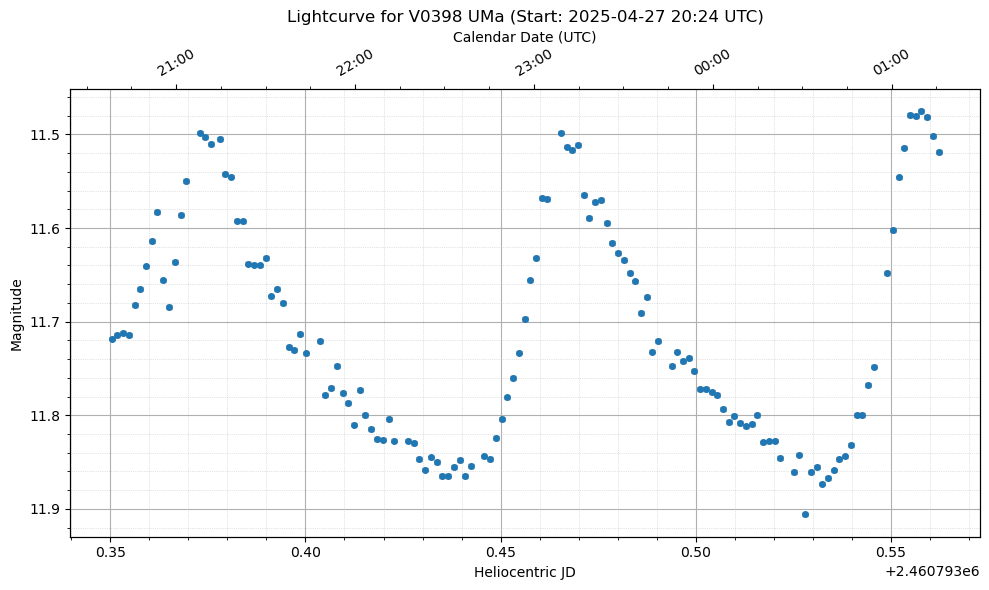

In [28]:
import matplotlib.pyplot as plt
from astropy.time import Time
import matplotlib.dates as mdates

# Convert HJD to datetime objects
times_helio = Time(df['HJD'].values, format='jd', scale='utc')
datetime_vals = times_helio.to_datetime()

# Create scatter plot with error bars
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(df['HJD'], df['MAG'], yerr=df['MERR'], fmt='o', ecolor='gray', capsize=2, markersize=4, label='Observations')
ax.invert_yaxis()  # Magnitude scale inverted
ax.set_xlabel('Heliocentric JD')
ax.set_ylabel('Magnitude')
start_dt = datetime_vals.min()
ax.set_title(f"Lightcurve for {object_name} (Start: {start_dt.strftime('%Y-%m-%d %H:%M')} UTC)")
ax.grid(True)  # Primary grid
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

# Twin axis: calendar date with dynamic formatting
ax2 = ax.twiny()
# Set twin x-limits to heliocentric datetime range in matplotlib date format
dt_min, dt_max = datetime_vals.min(), datetime_vals.max()
md_min, md_max = mdates.date2num(dt_min), mdates.date2num(dt_max)
ax2.set_xlim(md_min, md_max)
# Determine time span in days
span_days = df['HJD'].max() - df['HJD'].min()
if span_days < 1:
    # plot hours and minutes for short intervals
    locator = mdates.HourLocator()
    formatter = mdates.DateFormatter('%H:%M')
else:
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.setp(ax2.get_xticklabels(), rotation=30)
ax2.set_xlabel('Calendar Date (UTC)')
ax2.minorticks_on()

plt.tight_layout()
plt.show()

In [29]:
# Select data where the fractional part of HJD is between 0.4 and 0.5 for further processing
df_selected = df[(df['HJD'] % 1 > 0.4) & (df['HJD'] % 1 < 0.5)].copy()

print(f"Anzahl ausgewählter Datenpunkte: {len(df_selected)}")

Anzahl ausgewählter Datenpunkte: 62


# Data Export for Analysis Pipeline

## Standard Format Export

Exports the processed photometric data (HJD, magnitude, uncertainty) in a standardized CSV format. This file serves as input for specialized analysis notebooks:

- **exoplanet_fit.ipynb**: Bayesian parameter estimation for exoplanet transits
- **eclipsing_binary_fit.ipynb**: Analysis of eclipsing binary systems (future)
- **pulsating_variable_fit.ipynb**: Period analysis of pulsating variables (future)

The standardized format ensures consistency across different analysis methods.

In [30]:
from pathlib import Path
# Export selected columns to CSV
output_file = Path('data') / 'lc_obs.csv'
df_selected[['HJD','MAG','MERR']].to_csv(output_file, index=False)
print(f"Exported HJD, MAG, and MERR to {output_file}")

Exported HJD, MAG, and MERR to data\lc_obs.csv


# Synthetic Lightcurve Integration

## Model Comparison and Analysis

This section integrates synthetic lightcurves generated by the **exoplanet_fit.ipynb** notebook. The synthetic curve represents the best-fit theoretical model derived from Bayesian parameter estimation.

**Integration workflow:**
1. Load synthetic lightcurve from Bayesian analysis
2. Identify timing of minimum light (transit center)
3. Calculate uncertainties from MCMC sampling
4. Prepare data for BAV format export

This integration demonstrates the power of combining observational data with sophisticated theoretical models.

In [31]:
import pandas as pd
from pathlib import Path

synth_path ='.//data//lc_synth.csv'
df_synth = pd.read_csv(synth_path)

print("Synthetische Lichtkurve (erste Zeilen):")
display(df_synth.head())

Synthetische Lichtkurve (erste Zeilen):


,HJD,MAG
0,2.460793e+06,11.718131
1,2.460793e+06,11.718661
2,2.460793e+06,11.719189
3,2.460793e+06,11.719715
4,2.460793e+06,11.720239


# Minimum Time Determination

## Transit/Eclipse Timing Analysis

Determines the precise timing of minimum light from the synthetic lightcurve. This timing represents the best estimate of the transit center time, incorporating:

- **Heliocentric correction**: Applied consistently
- **Bayesian uncertainties**: From MCMC parameter estimation
- **Model-based interpolation**: Higher precision than direct observation

The timing precision is typically much better than individual photometric measurements due to the model-based approach combining all observations.

In [32]:
# Extremum der synthetischen Lichtkurve ermitteln
import numpy as np
from astropy.time import Time

#Festlegeung Minimum oder Maximum
M = 'Maximum'  # oder 'Mininum'

# Finde den Index des Minimums in der synthetischen Lichtkurve
if M == 'Maximum':
    min_idx = df_synth['MAG'].idxmin()  
else:
    min_idx = df_synth['MAG'].idxmax()

hjd_min = df_synth.loc[min_idx, 'HJD']
mag_min = df_synth.loc[min_idx, 'MAG']

print(f"Maximum der synthetischen Lichtkurve:")
print(f"  HJD: {hjd_min:.6f}")
print(f"  Magnitude: {mag_min:.6f}")

# Umrechnung zu UTC (ohne heliozentrische Korrektur)
# Dazu subtrahieren wir die heliozentrische Korrektur
# Verwende den Durchschnittswert der Delta_HJD als Näherung
avg_delta_hjd = df['Delta_HJD'].mean()
jd_min_utc = hjd_min - avg_delta_hjd

# Konvertiere zu UTC DateTime
time_min_hjd = Time(hjd_min, format='jd', scale='utc')
time_min_utc = Time(jd_min_utc, format='jd', scale='utc')

print(f"\nZeitpunkt des {M}:")
print(f"  HJD: {hjd_min:.6f}")
print(f"  JD (UTC, geozentrischer): {jd_min_utc:.6f}")
print(f"  UTC (heliozentrisch): {time_min_hjd.to_datetime().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"  UTC (geozentrisch): {time_min_utc.to_datetime().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
print(f"\nHeliozentrische Korrektur: {avg_delta_hjd:.6f} Tage = {avg_delta_hjd*24*60:.1f} Minuten")# Minimum der synthetischen Lichtkurve ermitteln


Maximum der synthetischen Lichtkurve:
  HJD: 2460793.468251
  Magnitude: 11.522245

Zeitpunkt des Maximum:
  HJD: 2460793.468251
  JD (UTC, geozentrischer): 2460793.466830
  UTC (heliozentrisch): 2025-04-27 23:14:16.896
  UTC (geozentrisch): 2025-04-27 23:12:14.080

Heliozentrische Korrektur: 0.001421 Tage = 2.0 Minuten


# Bayesian Parameter Uncertainties

## MCMC-Derived Uncertainties

Loads the parameter uncertainties derived from Hamiltonian Monte Carlo sampling in **exoplanet_fit.ipynb**. These uncertainties include:

**Statistical properties:**
- **Mean values**: Best-fit parameters
- **Standard deviations**: Parameter uncertainties
- **HDI intervals**: Highest Density Intervals (credible regions)
- **Correlations**: Parameter degeneracies and covariances

The Bayesian approach provides robust uncertainty estimates that properly account for parameter correlations and non-Gaussian posteriors.

In [33]:
import pandas as pd
from pathlib import Path

# Lade uncertainties.csv mit Zeilenindex
uncertainties_path = Path('data') / 'uncertainties.csv'
df_uncertainties = pd.read_csv(uncertainties_path, index_col=0)

print("Uncertainties Daten:")
print(f"Shape: {df_uncertainties.shape}")
print("\nErste Zeilen:")

# Print in float format instead of scientific notation
pd.set_option('display.float_format', '{:.4f}'.format)
display(df_uncertainties.head())
pd.reset_option('display.float_format')

print("\nSpalten:")
print(df_uncertainties.columns.tolist())

Uncertainties Daten:
Shape: (1, 4)

Erste Zeilen:


,mean,sd,hdi_3%,hdi_97%
parameter,,,,
tm,2460793.4682,0.0003,2460793.4677,2460793.4688



Spalten:
['mean', 'sd', 'hdi_3%', 'hdi_97%']


# Time System Conversions

## Coordinate Time Transformations

Converts between different time systems for proper documentation:

**Time systems:**
- **HJD**: Heliocentric Julian Date (barycentric corrections)
- **UTC**: Coordinated Universal Time (civil time standard)
- **JD**: Julian Date (geocentric, uncorrected)

These conversions ensure compatibility with different astronomical databases and software packages while maintaining traceability of corrections.

In [34]:
# Berechne UTC‐JD und UTC‐Zeitstempel für den heliocentrischen tm‐Wert
from astropy.time import Time

# Werte aus dem Index 'tm' ziehen
tm_hjd        = df_uncertainties.loc['tm', 'mean']
tm_sd_days    = df_uncertainties.loc['tm', 'sd']
hdi_low_hjd   = df_uncertainties.loc['tm', 'hdi_3%']
hdi_high_hjd  = df_uncertainties.loc['tm', 'hdi_97%']

# Geozentrische (UTC) JD: subtrahiere avg_delta_hjd
tm_utc_jd      = tm_hjd       - avg_delta_hjd
hdi_low_utc_jd = hdi_low_hjd   - avg_delta_hjd
hdi_high_utc_jd= hdi_high_hjd  - avg_delta_hjd

# In datetime konvertieren
tm_utc        = Time(tm_utc_jd,      format='jd', scale='utc').to_datetime()
hdi_low_utc   = Time(hdi_low_utc_jd, format='jd', scale='utc').to_datetime()
hdi_high_utc  = Time(hdi_high_utc_jd,format='jd', scale='utc').to_datetime()

# Standardabweichung in Minuten
tm_sd_min = tm_sd_days * 24 * 60

print(f"Heliozentrische JD tm:      {tm_hjd:.6f}")
print(f"Standardabweichung tm:        {tm_sd_days:.6e} Tage = {tm_sd_min:.3f} Minuten")
print(f"UTC JD tm:                   {tm_utc_jd:.6f}")
print(f"UTC Zeitpunkt tm:            {tm_utc}")
print()
print(f"Uncertainties UTC JD (hdi_low, hdi_high):        {hdi_low_utc_jd:.6f}, {hdi_high_utc_jd:.6f}")
print(f"Uncertainties UTC Zeitpunkt (hdi_low, hdi_high): {hdi_low_utc}, {hdi_high_utc}")

Heliozentrische JD tm:      2460793.468241
Standardabweichung tm:        3.189509e-04 Tage = 0.459 Minuten
UTC JD tm:                   2460793.466819
UTC Zeitpunkt tm:            2025-04-27 23:12:13.168758

Uncertainties UTC JD (hdi_low, hdi_high):        2460793.466244, 2460793.467422
Uncertainties UTC Zeitpunkt (hdi_low, hdi_high): 2025-04-27 23:11:23.490855, 2025-04-27 23:13:05.227217


# BAV MiniMax Format Export

## Standardized Variable Star Reporting

Generates data files compliant with BAV (Bundesdeutsche Arbeitsgemeinschaft für Veränderliche Sterne) standards for minimum time reporting:

**BAV MiniMax format includes:**
- Object identification (constellation + name)
- Precise timing (JD and HJD)
- Uncertainties from Bayesian analysis
- Observational metadata (filter, instrument, observer code)
- Statistical confidence measures

This format enables:
- Integration with international databases
- Comparison with historical observations
- Collaborative research coordination
- Long-term period change studies

In [35]:
# BAV MiniMax Datei erstellen
from pathlib import Path

# Extrahiere Werte für BAV Format
constellation_short = constellation  # bereits ermittelt
object_clean = object_name.replace(' ', '_').replace('-', '_')  # Leerzeichen durch Unterstriche ersetzen
jd_min = tm_utc_jd  # geozentrische JD
hjd_min_bav = tm_hjd  # heliozentrische JD
std_dev = tm_sd_days  # Standardabweichung in Tagen
mag_at_min = mag_min  # Magnitude im Minimum (aus synthetischer Kurve)
num_obs = len(df)  # Anzahl Beobachtungen

# Bestimme Filterband aus den Metadaten
filter_band = header_dict.get('Filter', 'V')  # Default zu V falls nicht vorhanden

# Dateiname nach BAV Konvention: Constellation_Object_HJD-2400000_DES_MiniMax.txt
# HJD minus 2400000 mit 4 Nachkommastellen für Dateiname
hjd_reduced = hjd_min_bav - 2400000
filename = f"{constellation_short}_{object_clean}_{hjd_reduced:.4f}_DES_MiniMax.txt"
output_path = Path('data') / filename

# BAV MiniMax Format schreiben
with open(output_path, 'w', encoding='utf-8') as f:
    f.write("#TYPE=BAVMiniMax\n")
    f.write("#Delim=|\n")
    
    # Hauptdatenzeile
    extremum_type = "min" if M.lower().startswith("min") else "max"
    line = f"{constellation_short}|{object_name}|{extremum_type}|{jd_min:.4f}|{hjd_min_bav:.4f}|{std_dev:.4f}|na|na|{mag_at_min:.3f}|C|ASI1600MM|{filter_band}|{num_obs}|DES|na|"
    f.write(line + "\n")

print(f"BAV MiniMax Datei erstellt: {output_path}")
print(f"\nInhalt der Datei:")
with open(output_path, 'r', encoding='utf-8') as f:
    print(f.read())

BAV MiniMax Datei erstellt: data\UMa_V0398_UMa_60793.4682_DES_MiniMax.txt

Inhalt der Datei:
#TYPE=BAVMiniMax
#Delim=|
UMa|V0398 UMa|max|2460793.4668|2460793.4682|0.0003|na|na|11.522|C|ASI1600MM|V|134|DES|na|



# BAV Report Format Export

## Complete Observation Dataset

Exports the complete photometric dataset in BAV Report format for archival purposes and detailed analysis by other researchers.

**Contents:**
- All individual measurements
- Timing in Julian Date
- Magnitude and uncertainty values
- Standardized precision formatting

This format preserves the complete observational record while ensuring compatibility with BAV analysis tools.

In [36]:
# Neue Zelle: BAVReport Datei erstellen
from pathlib import Path

# Dateiname analog zur MiniMax Datei, aber mit _BAVReport
report_filename = f"{constellation_short}_{object_clean}_{hjd_reduced:.4f}_DES_BAVReport.txt"
report_path = Path('data') / report_filename

# Schreibe BAV Report Header und Daten
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("#BAV Report\n")
    # Speichere die Spalten DATE, MAG, MERR ohne Header, mit 4 Nachkommastellen
    for _, row in df[['DATE', 'MAG', 'MERR']].iterrows():
        f.write(f"{row['DATE']:.4f} {row['MAG']:.4f} {row['MERR']:.4f}\n")

print(f"BAVReport Datei erstellt: {report_path}")

BAVReport Datei erstellt: data\UMa_V0398_UMa_60793.4682_DES_BAVReport.txt


# Final Publication Plot

## Comprehensive Analysis Summary

Creates the final publication-quality plot combining:

**Observational data:**
- Raw photometric measurements with error bars
- Heliocentric time corrections

**Theoretical model:**
- Synthetic lightcurve from Bayesian analysis
- Best-fit parameters with uncertainties

**Timing analysis:**
- Precise minimum determination
- Confidence intervals

**Metadata table:**
- Complete observational details
- Statistical analysis results
- Instrumental configuration

**Output formats:**
- High-resolution PNG for digital use
- Vector PDF for publication printing
- DIN A4 formatting for standard documentation

This final plot serves as a complete record of the analysis, suitable for scientific publication and archival documentation.

Plot gespeichert als:
  PNG: data\UMa_V0398_UMa_60793.4682_DES.png
  PDF: data\UMa_V0398_UMa_60793.4682_DES.pdf


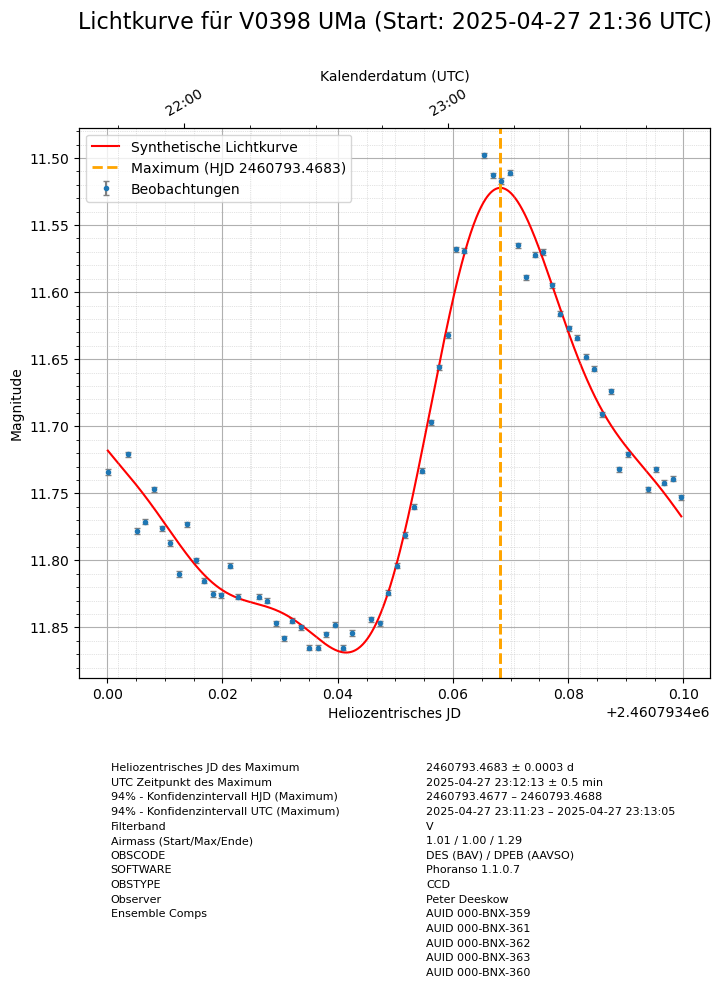

In [37]:
# Neue Zelle: Rohdaten und synthetische Lichtkurve plotten
import matplotlib.pyplot as plt
from astropy.time import Time
import matplotlib.dates as mdates

extremum_label = M if M.lower().startswith("min") else "Maximum"

# Beobachtungsdaten in datetime umwandeln
obs_times = Time(df_selected['HJD'].values, format='jd', scale='utc')
obs_dates = obs_times.to_datetime()

# Synthetische Kurve in datetime umwandeln
synth_times = Time(df_synth['HJD'].values, format='jd', scale='utc')
synth_dates = synth_times.to_datetime()

# DIN A4 Format (etwa 8.3 x 11.7 Zoll)
fig, ax = plt.subplots(figsize=(8.3, 11.7))
# Beobachtungen mit Fehlerbalken
ax.errorbar(df_selected['HJD'], df_selected['MAG'], yerr=df_selected['MERR'],
            fmt='o', ecolor='gray', capsize=2, markersize=3, label='Beobachtungen')
# Synthetische Kurve
ax.plot(df_synth['HJD'], df_synth['MAG'],
        '-', color='red', label='Synthetische Lichtkurve')

# Vertikale Linie für das Minimum
ax.axvline(hjd_min, color='orange', linestyle='--', linewidth=2, 
           label=f'{extremum_label} (HJD {hjd_min:.4f})')

ax.invert_yaxis()
ax.set_xlabel('Heliozentrisches JD')
ax.set_ylabel('Magnitude')
# Titelzeile mit Startdatum der Beobachtung ergänzen
start_dt = obs_dates.min()

ax.set_title(f"Lichtkurve für {object_name} (Start: {start_dt.strftime('%Y-%m-%d %H:%M')} UTC)", fontsize=16, pad=30)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
ax.legend()

# Vertikale Linie für das Minimum/Maximum
ax.axvline(hjd_min, color='orange', linestyle='--', linewidth=2, 
           label=f'{extremum_label} (HJD {hjd_min:.4f})')

# Zweite x-Achse mit Kalenderdatum
ax2 = ax.twiny()
md_min, md_max = mdates.date2num(obs_dates.min()), mdates.date2num(obs_dates.max())
ax2.set_xlim(md_min, md_max)
span = df['HJD'].max() - df['HJD'].min()
if span < 1:
    locator = mdates.HourLocator()
    formatter = mdates.DateFormatter('%H:%M')
else:
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.setp(ax2.get_xticklabels(), rotation=30)
ax2.set_xlabel('Kalenderdatum (UTC)')
ax2.minorticks_on()
ax2.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

# Diagramm mit angepassten Abständen für DIN A4 Format
fig.subplots_adjust(left=0.12, right=0.88, top=0.92, bottom=0.45)

# Build the metadata table rows including uncertainties as ± and T14 duration
table_data = [
    [f"Heliozentrisches JD des {extremum_label}",      f"{hjd_min:.4f} ± {tm_sd_days:.4f} d"],
    [f"UTC Zeitpunkt des {extremum_label}",             f"{tm_utc.strftime('%Y-%m-%d %H:%M:%S')} ± {tm_sd_min:.1f} min"],
    [f"94% - Konfidenzintervall HJD ({extremum_label})",            f"{hdi_low_hjd:.4f} – {hdi_high_hjd:.4f}"],
    [f"94% - Konfidenzintervall UTC ({extremum_label})",            f"{hdi_low_utc.strftime('%Y-%m-%d %H:%M:%S')} – {hdi_high_utc.strftime('%Y-%m-%d %H:%M:%S')}"],
    ["Filterband", f"{filter_band}"],
    ["Airmass (Start/Max/Ende)", f"{df['AIRMASS'].iloc[0]:.2f} / {df['AIRMASS'].min():.2f} / {df['AIRMASS'].iloc[-1]:.2f}"],
    #["Dauer des Minimums (T14)",               f"{df_uncertainties.loc['T14','mean']:.3f} d ({df_uncertainties.loc['T14','hdi_3%']:.3f} ... {df_uncertainties.loc['T14','hdi_97%']:.3f})"],
]
for key, value in header_dict.items():
    # skip unwanted metadata entries
    if key in ("TYPE", "DELIM", "DATE", "Observer Latitude", "Observer Longitude"):
        continue
    if key == "Ensemble Comps":
        comps = [c.strip() for c in value.split(',')]
        table_data.append([key, comps[0]])
        for comp in comps[1:]:
            table_data.append(['', comp])
    else:
        label = "DES (BAV) / DPEB (AAVSO)" if key == "OBSCODE" else value
        table_data.append([key, label])

# Metadaten als Tabelle unter dem Plot darstellen
tbl = ax.table(
    cellText=table_data,
    cellLoc="left",
    loc="bottom",
    bbox=[0, -0.55, 1, 0.4]
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1,4.0)  # increased row height
# Entferne Tabellenlinien
for cell in tbl._cells.values():
    cell.set_linewidth(0)

# Speichere Plot als PNG und PDF
plot_basename = f"{constellation_short}_{object_clean}_{hjd_reduced:.4f}_DES"
png_path = Path('data') / f"{plot_basename}.png"
pdf_path = Path('data') / f"{plot_basename}.pdf"

plt.savefig(png_path, dpi=300, bbox_inches='tight', format='png')
plt.savefig(pdf_path, bbox_inches='tight', format='pdf')

print(f"Plot gespeichert als:")
print(f"  PNG: {png_path}")
print(f"  PDF: {pdf_path}")

plt.show()